# NOTEBOOK 4: CLUSTERING 
### Team 3
- Anjali Sebastian
- Yesha Sharma
- Rupansh Phutela

### What this Notebook does?
After Data selection, cleaning, pre-processing, EDA and Regression Analysis, we will now look at how we can perform cluster our data. Although our data has already target varibale y = Diabetes (Yes or No) we will try to cluster the data to see if any new patterns emerge. 
 - Normalization of entire dataset due to varying ranges of different attributes
 - Simple Visualization of the Dataset
 - Cluster using Agglomerative Clustering
 - Cluster using K-Means Clustering
 - Cluster using Mini Batch K-Means Clustering
 - Cluster using MeanShift
 - Comparing clustering algorithmn with two clusters vis a vis real target labels. Here we assume C1 as label=0 (No Diabetes) and C2 as label = 1 (yes Diabetes) for doing our comparision . This can be flipped since the cluster created can have any meaning as such. ( however in most cases we can reasonably assume 1 of the clusters to correspond to 1 of the target labels.
 - Analysis of all the clustering algorithms and Conclusion

## 1. Import Packages and Setup

In [1]:
# you need   Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)


In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [3]:
import os
import pandas as pd   
import numpy as np    
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
##############################################

In [4]:
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# method to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## 2. Utility Functions

In [5]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00','#00AAFF','#000000','#FF00AA','#2ca02c', '#d62728','#9467bd','#8c564b','#e377c2']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()
    
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## 3. Read Data and Display

In [6]:
diabetes = pd.read_csv('./diabetes.csv')

In [7]:
diabetes.head()

,Unnamed: 0,Diabetes,BMI,State,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0,0.0,28.17,AL,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,3.0,15.0,0.0,1.0,0.0,13.0,3.0,3.0
1,1,0.0,18.54,AL,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,2.0,10.0,0.0,0.0,0.0,11.0,5.0,5.0
2,2,1.0,31.62,AL,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,1.0,3.0,0.0,30.0,1.0,0.0,10.0,6.0,7.0
3,6,1.0,32.98,AL,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,4.0,30.0,0.0,1.0,1.0,11.0,6.0,7.0
4,9,1.0,16.65,AL,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,20.0,0.0,1.0,0.0,11.0,2.0,3.0


In [8]:
#set datatypes of columns to boolean or categorical as appropriate
make_bool_int = ['Diabetes','HighBP','HighChol','CholCheck',\
             'FruitConsume','VegetableConsume','Smoker','HeavyDrinker','Stroke','HeartDisease',\
             'Healthcare','NoDoctorDueToCost','PhysicalActivity','DifficultyWalking','Gender']
make_categorical_int = ['GeneralHealth','Age','Education','Income']

In [9]:
#drop the extra index column in datafram
diabetes=diabetes.drop(['Unnamed: 0'], axis=1)

#drop the state column in dataframe since it will not be used in the dataframe
diabetes=diabetes.drop(['State'], axis=1)

In [10]:
diabetes.head()

,Diabetes,BMI,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,HeavyDrinker,Stroke,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0.0,28.17,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,3.0,15.0,0.0,1.0,0.0,13.0,3.0,3.0
1,0.0,18.54,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,2.0,10.0,0.0,0.0,0.0,11.0,5.0,5.0
2,1.0,31.62,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,3.0,0.0,30.0,1.0,0.0,10.0,6.0,7.0
3,1.0,32.98,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,4.0,30.0,0.0,1.0,1.0,11.0,6.0,7.0
4,1.0,16.65,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,20.0,0.0,1.0,0.0,11.0,2.0,3.0


In [11]:
# deep copy before next stage
df = diabetes.copy(deep = True)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243317 entries, 0 to 243316
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Diabetes           243317 non-null  float64
 1   BMI                243317 non-null  float64
 2   HighBP             243317 non-null  float64
 3   HighChol           243317 non-null  float64
 4   CholCheck          243317 non-null  float64
 5   FruitConsume       243317 non-null  float64
 6   VegetableConsume   243317 non-null  float64
 7   Smoker             243317 non-null  float64
 8   HeavyDrinker       243317 non-null  float64
 9   Stroke             243317 non-null  float64
 10  HeartDisease       243317 non-null  float64
 11  Healthcare         243317 non-null  float64
 12  NoDoctorDueToCost  243317 non-null  float64
 13  PhysicalActivity   243317 non-null  float64
 14  GeneralHealth      243317 non-null  float64
 15  PhysicalHealth     243317 non-null  float64
 16  Me

In [13]:
df.shape

(243317, 22)

## 4. Normalization and Simple Vizualization

In [14]:
X_columns = ['BMI', 'HighBP', 'HighChol', 'CholCheck', 'FruitConsume',
       'VegetableConsume', 'Smoker', 'HeavyDrinker', 'Stroke', 'HeartDisease',
       'Healthcare', 'NoDoctorDueToCost', 'PhysicalActivity', 'GeneralHealth',
       'PhysicalHealth', 'MentalHealth', 'DifficultyWalking', 'Gender', 'Age',
       'Education', 'Income']

Note: The entire data set is 0.24 million enteries. The agglomerative clustering and Mean Shift clustering algorithms we causing the kernal to crash because the sized of data set is too large. So we are going to take a random sample of 10,000 entries to perform clustering and see how all the clustering algorithmns perform.

In [15]:
# Selecting a random sample for the data set

#sampling a random number of values since plotting all 0.2 million datapoints will crash the kernal
number_of_samples = 10000
df_sample = df.sample(number_of_samples, random_state=42)

Text(0.5, 1.0, 'Vizualizing the full data (attributes BMI, HighBP). Not Normalized')

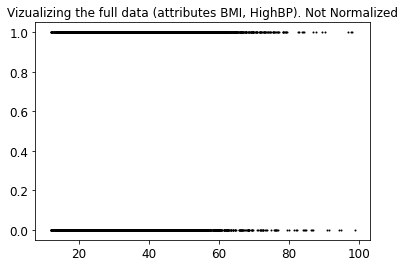

In [16]:
# separating the target column y = Diabetes before clustering
# for complete dataset
X_df = df[X_columns].values
y_df = df[['Diabetes']]
plot_data(X_df)
plt.title("Vizualizing the full data (attributes BMI, HighBP). Not Normalized")

Text(0.5, 1.0, 'Vizualizing the  data (attributes BMI, HighBP). Not Normalized')

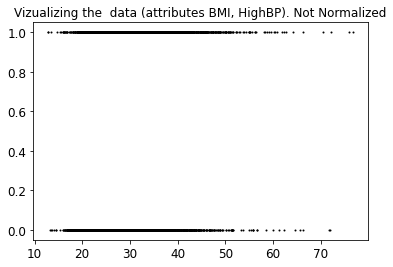

In [17]:
# separating the target column y = Diabetes before clustering

# for sampled dataset
X_sample_df = df_sample[X_columns].values
y_sample_df = df_sample[['Diabetes']]
plot_data(X_sample_df)
plt.title("Vizualizing the  data (attributes BMI, HighBP). Not Normalized")

Text(0.5, 1.0, 'Vizualizing the full data (attributes BMI, HighBP). Normalized')

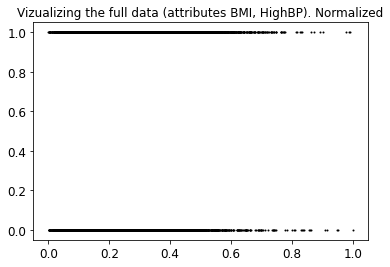

In [18]:
# Using minmax scaler for normalization
from sklearn.preprocessing import MinMaxScaler

# normalization full dataset
X_normalized = MinMaxScaler().fit(X_df).transform(X_df)
df_normalized = pd.DataFrame(X_normalized, columns=X_columns )
plot_data(X_normalized)
plt.title("Vizualizing the full data (attributes BMI, HighBP). Normalized")

Text(0.5, 1.0, 'Vizualizing the sample data (attributes BMI, HighBP). Normalized')

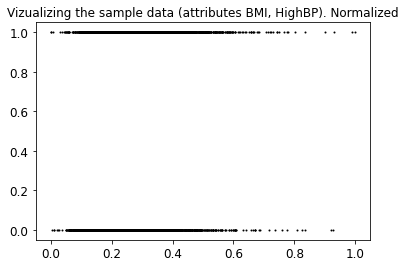

In [19]:
# normalization sample dataset
X_sample_normalized = MinMaxScaler().fit(X_sample_df).transform(X_sample_df)
df_sample_normalized = pd.DataFrame(X_sample_normalized, columns=X_columns )
plot_data(X_sample_normalized)
plt.title("Vizualizing the sample data (attributes BMI, HighBP). Normalized")

In [20]:
# Normalized features in pandas format
df_normalized.head()

,BMI,HighBP,HighChol,CholCheck,FruitConsume,VegetableConsume,Smoker,HeavyDrinker,Stroke,HeartDisease,...,NoDoctorDueToCost,PhysicalActivity,GeneralHealth,PhysicalHealth,MentalHealth,DifficultyWalking,Gender,Age,Education,Income
0,0.186505,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.50,0.500000,0.0,1.0,0.0,1.000000,0.4,0.285714
1,0.075433,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.25,0.333333,0.0,0.0,0.0,0.833333,0.8,0.571429
2,0.226298,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.50,0.000000,1.0,1.0,0.0,0.750000,1.0,0.857143
3,0.241984,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.75,1.000000,0.0,1.0,1.0,0.833333,1.0,0.857143
4,0.053633,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.666667,0.0,1.0,0.0,0.833333,0.2,0.285714


In [21]:
# Normalized features in numpy format
X_normalized

array([[0.18650519, 1.        , 1.        , ..., 1.        , 0.4       ,
        0.28571429],
       [0.07543253, 0.        , 0.        , ..., 0.83333333, 0.8       ,
        0.57142857],
       [0.22629758, 1.        , 0.        , ..., 0.75      , 1.        ,
        0.85714286],
       ...,
       [0.1905421 , 0.        , 0.        , ..., 0.5       , 0.4       ,
        0.        ],
       [0.227797  , 0.        , 1.        , ..., 0.        , 0.6       ,
        0.28571429],
       [0.09192618, 0.        , 0.        , ..., 0.33333333, 1.        ,
        1.        ]])

Note: The data pairs are as follows:
- Full Data
    1. X_df (pandas) with y_df(pandas) : not normalized full data set
    2. X_normalized (numpy) with y_df(pandas) : normalized full X in numpy (easy for clustering)
    3. df_normalized (pandas) with y_df(pandas) : normalized X in pandas format (easy for tracking feature names)
- Sample Data of 10,000 randomly selected rows
    1. X_sample_df (pandas) with y_sample_df(pandas) : not normalized sample data set
    2. X_df_normalized (numpy) with y_sample_df(pandas) : normalized sample X in numpy (easy for clustering)
    3. df_sample_normalized (pandas) with y_sample_df(pandas) : normalized X sample in pandas format (easy for tracking feature names)
    
- For all our clustering we will use only the normalized versions of the dataset.    

## 5. AGGLOMERATIVE CLUSTERING
- For agglomerative Clustering we will only use the samples dataset (10,000) values as the dendrogram will not be visualized properly if all 0.24 million data points are used.
- df_sample_normalized

#### Apply Agglomerative Clustering

In [22]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
aggo = AgglomerativeClustering(distance_threshold=0,n_clusters=None)
aggo = aggo.fit(df_sample_normalized)

#### Dendrogram Vizualization

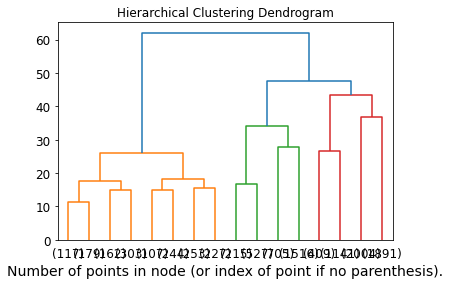

In [23]:
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(aggo, truncate_mode="level", p=3, )
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Notes: Using the dendogram we can see that we can go with either 3 clusters or 2 clusters.

#### Compare Clustering Generated Labels with Known Labels

In [24]:
# Use agglomerative Clustering to make 2 clusters
aggo_2c = AgglomerativeClustering(n_clusters=2)
aggo_2c = aggo_2c.fit(df_sample_normalized)
aggo_2c.labels_

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

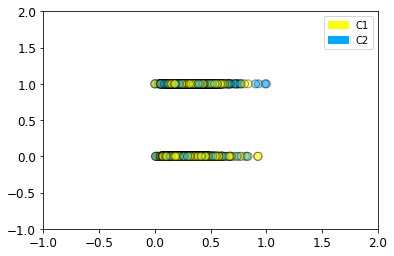

In [25]:
# Labels Generated By Agglomerative Clustering
plot_labelled_scatter(X_sample_normalized, aggo_2c.labels_, ['C1', 'C2'])

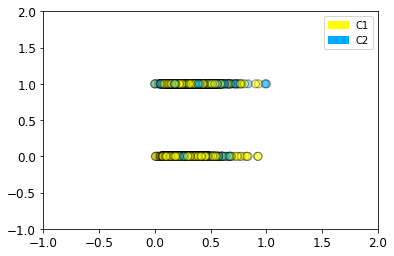

In [26]:
# Known Labels from target y = Diabetes
plot_labelled_scatter(X_sample_normalized, y_sample_df.to_numpy(), ['C1', 'C2'])

In [27]:
# find similarity between the labels
df_temp = pd.DataFrame(aggo_2c.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_sample_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 79.67999999999999


In [28]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Cluster_Labels'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
percentage_positive
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.3527443105756359


## 6. KMEANS CLUSTERING 
- KMeans is a very computationatility efficent algo. It is able to cluster the entire dataset in reasonable time   

#### Simple KMeans Models
-With 2,3,and 4 clusters

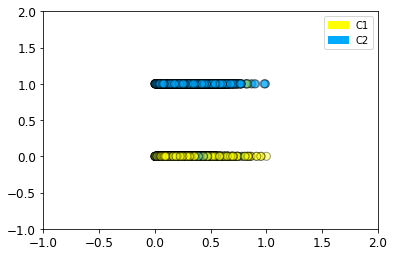

In [29]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_normalized)
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2'])

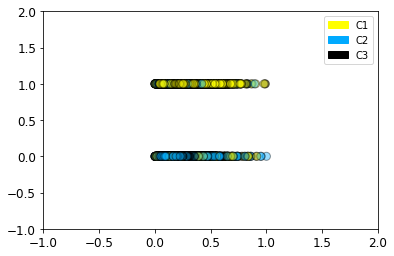

In [30]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X_normalized)
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2','C3'])

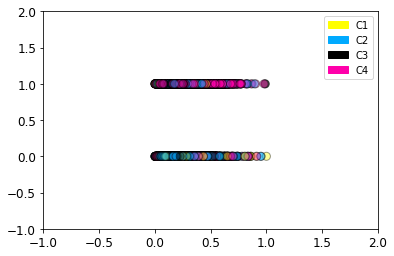

In [31]:
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X_normalized)
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2','C3','C4'])

#### Inertia Measures

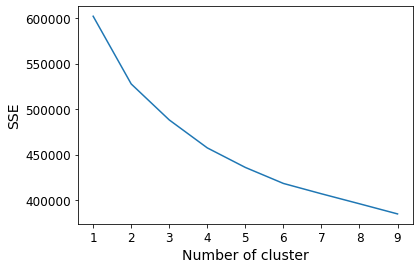

In [32]:
sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X_normalized)
    df["clusters"] = kmeans.labels_

    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

####  Silhouette Score
- Generating a silloutte score is computationally expensive so we are doing it for only the sample dataset


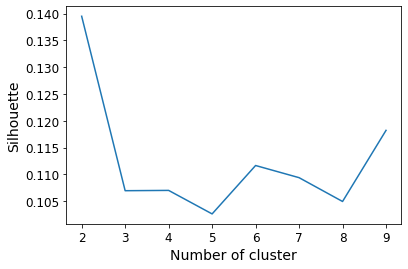

In [33]:
# using only 10000 samples 
from sklearn import metrics
score = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_sample_normalized)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(df_sample_normalized, labels, metric='euclidean')

plt.figure()
plt.plot(list(score.keys()), list(score.values()))
plt.xlabel("Number of cluster")
plt.ylabel("Silhouette")
plt.show()

#### Vizualizing Kmeans for different cluster numbers

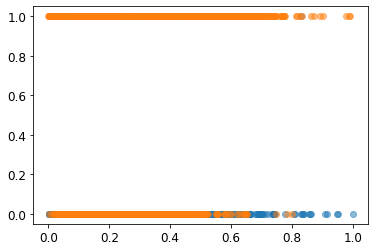

In [34]:
model_2c = KMeans(n_clusters=2)
model_2c.fit(X_normalized)
yhat = model_2c.predict(X_normalized)
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where (yhat == cluster)
    plt.scatter(X_normalized[row_ix,0],X_normalized[row_ix,1],alpha = 0.5)

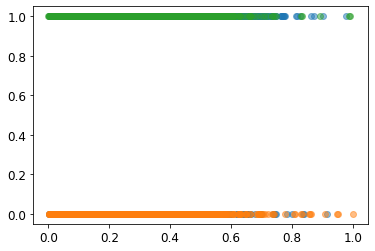

In [35]:
model_3c = KMeans(n_clusters=3)
model_3c.fit(X_normalized)
yhat = model_3c.predict(X_normalized)
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where (yhat == cluster)
    plt.scatter(X_normalized[row_ix,0],X_normalized[row_ix,1],alpha = 0.5)

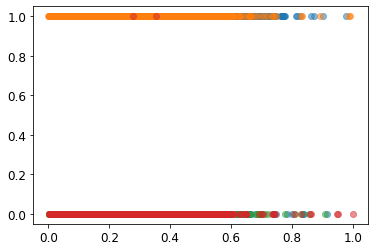

In [36]:
model_4c = KMeans(n_clusters=4)
model_4c.fit(X_normalized)
yhat = model_4c.predict(X_normalized)
clusters = np.unique(yhat)
for cluster in clusters:
    row_ix = np.where (yhat == cluster)
    plt.scatter(X_normalized[row_ix,0],X_normalized[row_ix,1],alpha = 0.5)

Note: Choice of number of clusters. Looking at agglomerative clustering we should choose either 2 or 3 cluster. Looking at the inertia score 2,3 or 4 . Using silouttte score 2 , 5 or 7 would be a good option. Since we know that the target label has 2 class "Has diabetes" and "Does not have diabetes" n_clusters = 2 would be a good choice  

#### Compare Clustering Generated Labels with Known Labels

In [37]:
# Kmeans with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_normalized)

KMeans(n_clusters=2, random_state=0)

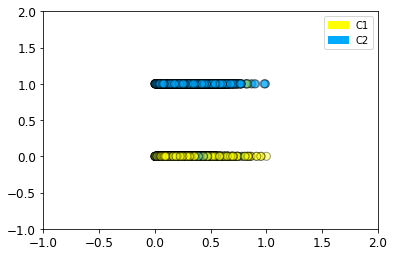

In [38]:
# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2'])

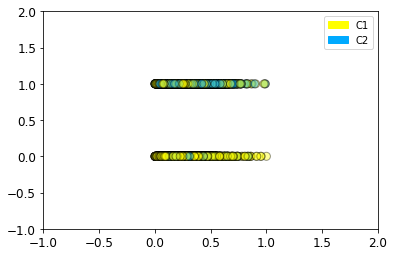

In [39]:
# using actual target labels
plot_labelled_scatter(X_normalized, y_df.to_numpy(), ['C1', 'C2'])

In [40]:
# find similarity between the labels
df_temp = pd.DataFrame(kmeans.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
df_similarity.head()

,Diabetes,Cluster_Labels
0,0.0,1
1,0.0,0
2,1.0,1
3,1.0,0
4,1.0,1


In [41]:
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 63.39589917679406


In [42]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Cluster_Labels'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.7845548032522168


Note: 63.39% and percentage positive is across the entire dataset 

In [43]:
# Kmeans with 2 clusters or sample
kmeans_s = KMeans(n_clusters=2, random_state=0)
kmeans_s.fit(X_sample_normalized)

# find similarity between the labels
df_temp = pd.DataFrame(kmeans_s.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_sample_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)

same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)


The percentage of datapoints that were in the cluster with similar label to known label 65.91


In [44]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Cluster_Labels'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.7831325301204819


Note: 65.91% is for the sample of 10,000 datapoints

### 7. KMeans Mini Batch
- We are doing MiniBatch for 2 clusters with different batch sizes (8,32,128)
- First we will find ideal cluster numbers for different batch sizes using intertia and silloutte score

In [45]:
from sklearn.cluster import MiniBatchKMeans

#### Inertia Measure
- Batch Size = 8, 32, 64, 128

Text(0.5, 1.0, 'Batch size = 128')

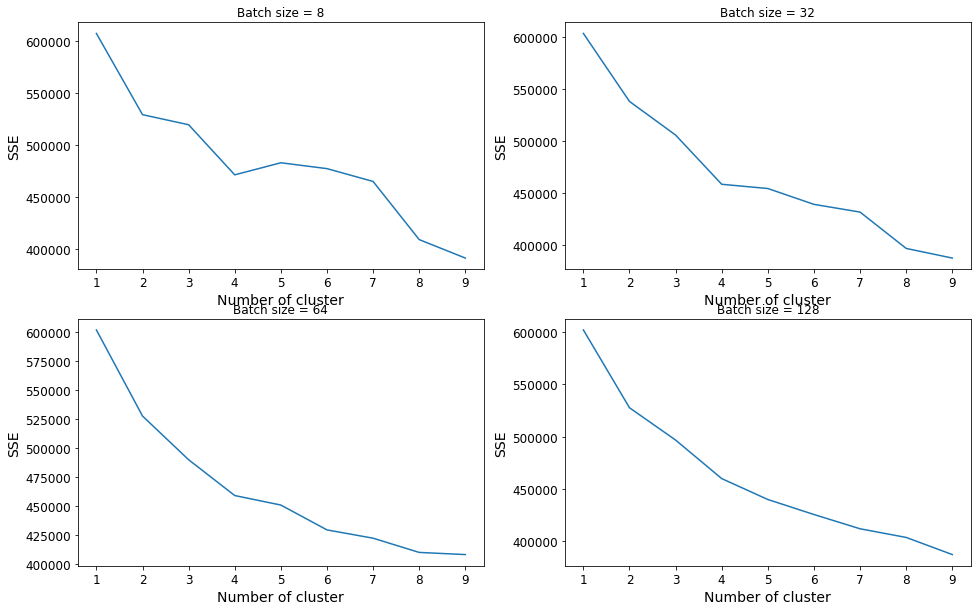

In [46]:
sse = {}
for k in range(1, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=8, max_iter=100).fit(X_normalized)
    df["clusters"] = kmeans.labels_

    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 

fig, ([ax1, ax2], [ax3,ax4]) = plt.subplots(2, 2)
fig.set_size_inches(16, 10)
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Number of cluster")
ax1.set_ylabel("SSE")
ax1.set_title("Batch size = 8")

sse = {}
for k in range(1, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=32, max_iter=100).fit(X_normalized)
    df["clusters"] = kmeans.labels_

    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 


ax2.plot(list(sse.keys()), list(sse.values()))
ax2.set_xlabel("Number of cluster")
ax2.set_ylabel("SSE")
ax2.set_title("Batch size = 32")


sse = {}
for k in range(1, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=64, max_iter=100).fit(X_normalized)
    df["clusters"] = kmeans.labels_

    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 


ax3.plot(list(sse.keys()), list(sse.values()))
ax3.set_xlabel("Number of cluster")
ax3.set_ylabel("SSE")
ax3.set_title("Batch size = 64")


sse = {}
for k in range(1, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=128, max_iter=100).fit(X_normalized)
    df["clusters"] = kmeans.labels_

    # Inertia: Sum of distances of samples to their closest cluster center
    sse[k] = kmeans.inertia_ 


ax4.plot(list(sse.keys()), list(sse.values()))
ax4.set_xlabel("Number of cluster")
ax4.set_ylabel("SSE")
ax4.set_title("Batch size = 128")

Note Looking at the inertia measures for different batch sizes we can see that there are elbows at 2, 4 and 8 clusters which is prominent. As we increase the batch size the intertia curve looks very similar to the one we plotted for the Kmeans algorithm.  

Text(0, 0.5, 'Silhouette')

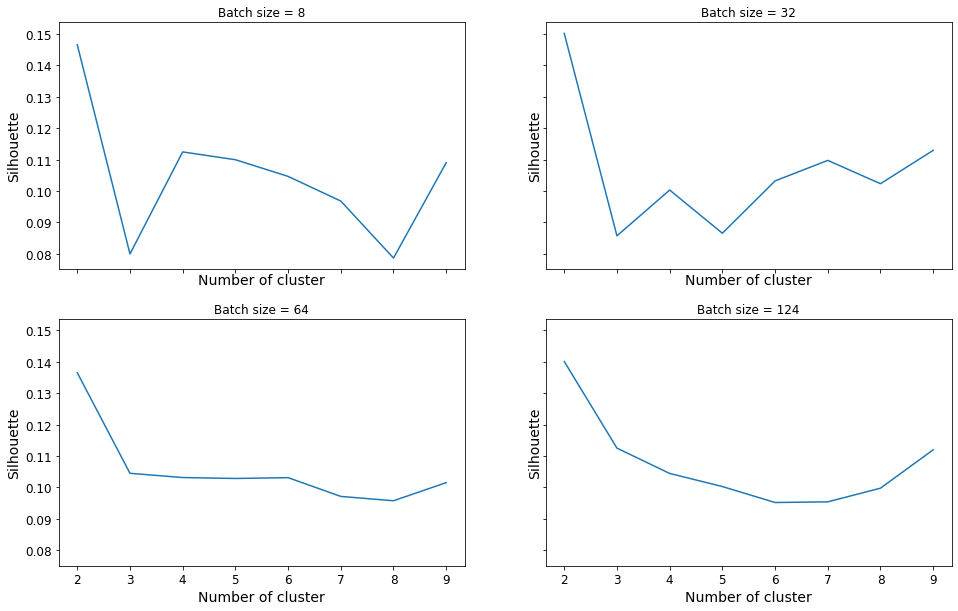

In [47]:
# using only 10,000 samples 
number_of_samples = 10000
df_sample = df_normalized.sample(number_of_samples, random_state=42)
X_sample = df_sample.to_numpy()

fig, ([ax1, ax2], [ax3,ax4]) = plt.subplots(2,2,sharex=True, sharey=True)
fig.set_size_inches(16, 10)


score = {}
for k in range(2, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=8, max_iter=100).fit(df_sample)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(df_sample, labels, metric='euclidean')

ax1.plot(list(score.keys()), list(score.values()))
ax1.set_xlabel("Number of cluster")
ax1.set_ylabel("Silhouette")
ax1.set_title("Batch size = 8")

score = {}
for k in range(2, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=32, max_iter=100).fit(df_sample)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(df_sample, labels, metric='euclidean')

ax2.plot(list(score.keys()), list(score.values()))
ax2.set_xlabel("Number of cluster")
ax2.set_ylabel("Silhouette")
ax2.set_title("Batch size = 32")

score = {}
for k in range(2, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=64, max_iter=100).fit(df_sample)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(df_sample, labels, metric='euclidean')

ax3.plot(list(score.keys()), list(score.values()))
ax3.set_xlabel("Number of cluster")
ax3.set_ylabel("Silhouette")
ax3.set_title("Batch size = 64")

score = {}
for k in range(2, 10):
    kmeans = MiniBatchKMeans(n_clusters=k,random_state=0,batch_size=128, max_iter=100).fit(df_sample)
    labels = kmeans.labels_

    score[k] = metrics.silhouette_score(df_sample, labels, metric='euclidean')

ax4.plot(list(score.keys()), list(score.values()))
ax4.set_xlabel("Number of cluster")
ax4.set_ylabel("Silhouette")
ax4.set_title("Batch size = 124")

plt.xlabel("Number of cluster")
plt.ylabel("Silhouette")

Note Looking at the silloutte measures for different batch sizes we can see that 2 , 4 and 7  .which is prominent. As we increase the batch size the intertia curve looks very similar to the one we plotted for the Kmeans algorithm.
Based on both Inertia and Siloutte scores cluster size of 2 or 4 is good option.

#### Mini Batch KMeans Models for 4 Clusters 

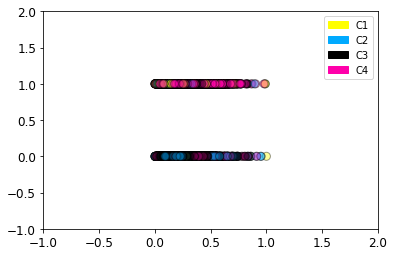

In [48]:
# Kmeans Mini batch with 4 clusters
# Batch Size = 8
kmeans = MiniBatchKMeans(n_clusters=4,random_state=0,batch_size=8, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2','C3','C4'])

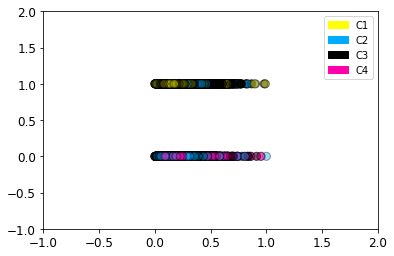

In [49]:
# Kmeans Mini batch with 4 clusters
# Batch Size = 32
kmeans = MiniBatchKMeans(n_clusters=4,random_state=0,batch_size=32, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2','C3','C4'])

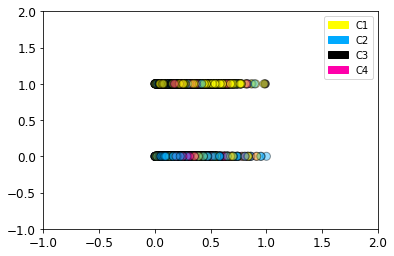

In [50]:
# Kmeans Mini batch with 4 clusters
# Batch Size = 64
kmeans = MiniBatchKMeans(n_clusters=4,random_state=0,batch_size=64, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2','C3','C4'])

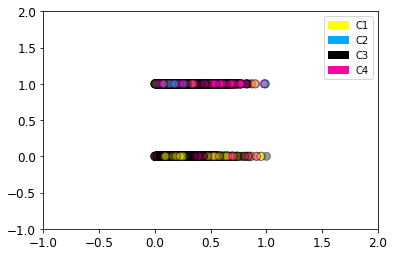

In [51]:
# Kmeans Mini batch with 4 clusters
# Batch Size = 128
kmeans = MiniBatchKMeans(n_clusters=4,random_state=0,batch_size=128, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2','C3','C4'])

#### Mini Batch KMeans Models Clusters = 2
- all models are for two clusters
- diffrent batch sizes of 8,32,64 and 128
- comparing the generated labels with known labels

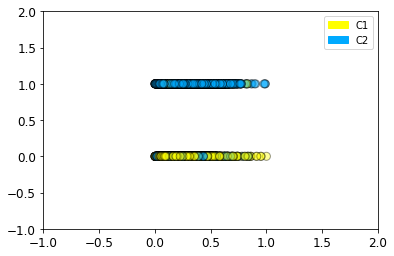

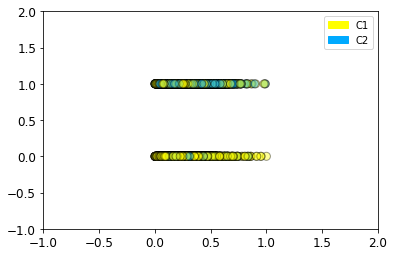

In [52]:
# Kmeans Mini batch with 2 clusters
kmeans = MiniBatchKMeans(n_clusters=2,random_state=0,batch_size=8, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2'])

# using actual target labels
plot_labelled_scatter(X_normalized, y_df.to_numpy(), ['C1', 'C2'])

In [53]:
# find similarity between the labels
df_temp = pd.DataFrame(kmeans.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 65.18821126349576


In [54]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Cluster_Labels'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.7825150854131845


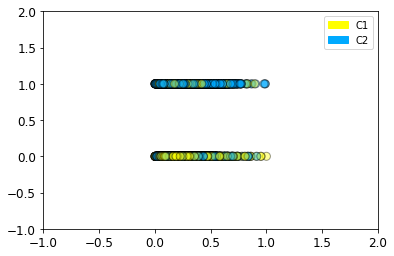

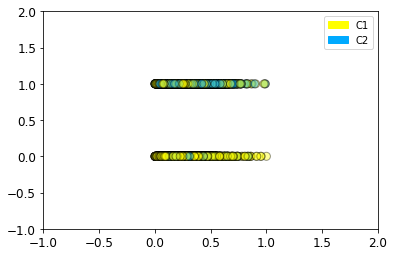

In [55]:
# Kmeans Mini batch with 2 clusters
kmeans = MiniBatchKMeans(n_clusters=2,random_state=0,batch_size=32, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2'])

# using actual target labels
plot_labelled_scatter(X_normalized, y_df.to_numpy(), ['C1', 'C2'])

In [56]:
# find similarity between the labels
df_temp = pd.DataFrame(kmeans.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 71.58069514255067


In [57]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Cluster_Labels'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.648941896371002


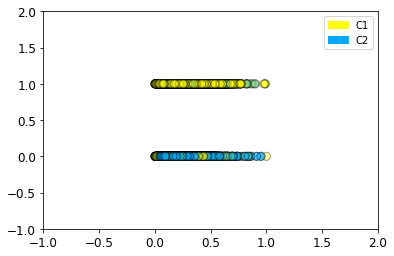

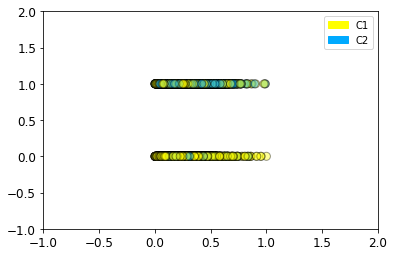

In [58]:
# Kmeans Mini batch with 2 clusters
kmeans = MiniBatchKMeans(n_clusters=2,random_state=0,batch_size=64, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2'])

# using actual target labels
plot_labelled_scatter(X_normalized, y_df.to_numpy(), ['C1', 'C2'])

In [59]:
# find similarity between the labels
df_temp = pd.DataFrame(kmeans.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 34.40491211053892


Note: 34.40 here the cluster labels might be inverted vis a vis the actual labels. So We will recalculate the similarity by flipping cluster label 0 to 1 and 1 to 0. 

In [60]:
df_similarity['Cluster_Labels'].value_counts()

1    139957
0    103360
Name: Cluster_Labels, dtype: int64

In [61]:
df_similarity['Flipped_cluster_label'] = 0
df_similarity.loc[df_similarity['Cluster_Labels']==0,'Flipped_cluster_label'] = 1
df_similarity.head()

,Diabetes,Cluster_Labels,Flipped_cluster_label
0,0.0,0,1
1,0.0,1,0
2,1.0,0,1
3,1.0,1,0
4,1.0,0,1


In [62]:
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Flipped_cluster_label'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 65.59508788946108


In [63]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Flipped_cluster_label'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.778294002662965


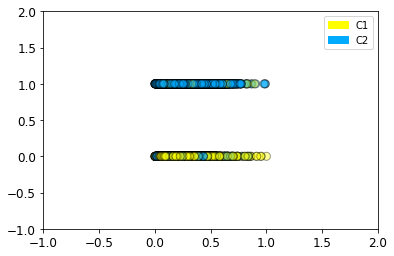

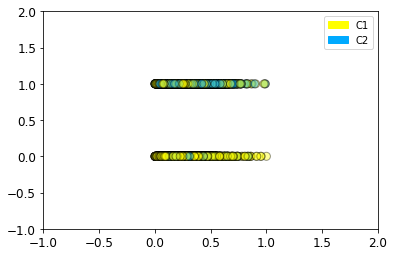

In [64]:
# Kmeans Mini batch with 2 clusters
kmeans = MiniBatchKMeans(n_clusters=2,random_state=0,batch_size=128, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)

# cluster labels
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2'])

# using actual target labels
plot_labelled_scatter(X_normalized, y_df.to_numpy(), ['C1', 'C2'])

In [65]:
# find similarity between the labels
df_temp = pd.DataFrame(kmeans.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 65.91360241988846


In [66]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Cluster_Labels'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.7758293436074676


Note: Looking at the above similarities. Kmeans Mini Batch with Batch Size = 32 is doing a fairly good job at making the clusters. The clusters have some relation to the traget labels . At least 71 % corresponding labels and 65% pick up of label = 1 (we are more interested in positive labels).  

### 8. Mean Shift Clustering
- we use estimate_bandwidth to get a intial bandwidth that we start we.

#### Mean Shift Clustering with Estimated Bandwidth

In [67]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# The following bandwidth can be automatically detected using estimate_bandwith
bandwidth = estimate_bandwidth(X_normalized, quantile=0.2, n_samples=5000)
bandwidth

1.8248125202090706

In [68]:
#sampling a random number of values since plotting all 0.2 million datapoints will crash the kernal

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True,n_jobs=-1)
ms.fit(df_sample_normalized)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 1


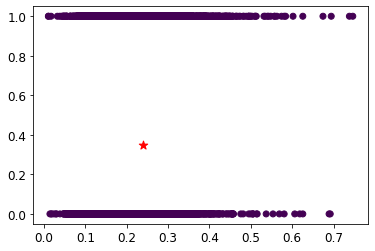

In [69]:
X_sample = df_sample.to_numpy()
plt.scatter(X_sample[:,0],X_sample[:,1],c=labels)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker="*",color="r",s=80)

Note: Meanshift with the estimated bandwidth is resulting in only 1 cluster.

#### Mean Shift Model with Lower Bandwidth to Produce atleast  2 clusters  

In [70]:
 ms = MeanShift(bandwidth=1.6, bin_seeding=True,n_jobs=-1)
ms.fit(df_sample_normalized)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 2


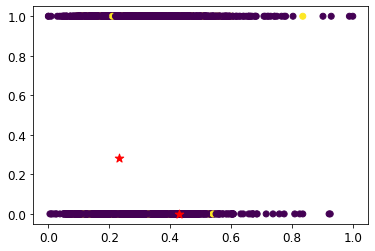

In [71]:
X_sample = df_sample_normalized.to_numpy()
plt.scatter(X_sample[:,0],X_sample[:,1],c=labels)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],marker="*",color="r",s=80)

Note: We have reduced the bandwidth so that two cluster centres arise. However here the cluster centers do not make much sense

In [72]:
# find similarity between the labels
# find similarity between the labels
df_temp = pd.DataFrame(ms.labels_, columns=["Cluster_Labels"] )
df_similarity = pd.concat([y_sample_df.reset_index(drop=True), df_temp.reset_index(drop=True)], axis= 1)
same = df_similarity.loc[df_similarity['Diabetes'] == df_similarity['Cluster_Labels'],:]
total_correct = same.shape[0]/df_similarity.shape[0]*100
print("The percentage of datapoints that were in the cluster with similar label to known label", total_correct)

The percentage of datapoints that were in the cluster with similar label to known label 84.39999999999999


In [73]:
correct_positive =  df_similarity.loc[(df_similarity['Diabetes'] == df_similarity['Cluster_Labels'])&(df_similarity['Diabetes'] == 1) ,:]
total_known_positive = df_similarity.loc[df_similarity['Diabetes'] == 1 ,:]
percentage_positive = correct_positive.shape[0]/total_known_positive.shape[0]
print("Total Percentage of positive over actuals", percentage_positive)

Total Percentage of positive over actuals 0.028112449799196786


# Conclusion

In [74]:
# PCA DO WE DO IT WITH KMEANS?????? 

Key assumption in the comparisions between the cluster generated labels and the target labels is that C1 = 0 is no diabetes and C2 = 1 is yes diabetic. If the correspondence is less than 50% then it is possible that the cluster labels are actually reversed. We can never be sure. But in almost all our models the label matching between C1 = 0 and C2 = 1 is higher than 65% so we can try to find which model has clusters  that are relating more closely to our target labels.

It looks like 2 clusters with Kmeans or mini batch kmeans is the best. It is also better in terms of computational complexity and understandability. In the KMeans Mini Batch with batch size 32 the two clusters formed have a good not great correspondence to the actual labels of the target (No,Yes) Diabetes
- 71 % overall and 65% of positive labels were matching between the cluster created labels and actual labels

After completing the classification analysis we can further try and relate our classification results to our clustering results.

More writeup Please !!!

# REFERENCES 

https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/

https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

https://mclguide.readthedocs.io/en/latest/sklearn/clusterdim.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

https://www.codecademy.com/learn/machine-learning/modules/dspath-clustering/cheatsheet

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://towardsdatascience.com/clustering-how-to-find-hyperparameters-using-inertia-b0343c6fe819

Material from Machine Learning Course, Seattle University  

Material from Introduction to Data Science, Seattle University  

# --END--

In [76]:
from sklearn.decomposition import PCA

In [80]:
X_normalized.shape

(243317, 2)

In [78]:
# Kmeans Mini batch with 2 clusters
kmeans = MiniBatchKMeans(n_clusters=2,random_state=0,batch_size=32, max_iter=100).fit(X_normalized)
kmeans.fit(X_normalized)


#PCA
# Clustering using KMeans
centroids, labels = kmeans.cluster_centers_, kmeans.labels_
print(centroids)
print(labels)

# Dimesionality reduction to 2
pca_model = PCA(n_components=2)
pca_model.fit(X_normalized) # fit the model
X_normalized = pca_model.transform(X_normalized) # transform the 'normalized model'


# transform the 'centroids of KMean'
centroid_pca = pca_model.transform(centroids)
print(centroid_pca)

# # cluster labels
# plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2'])

# # using actual target labels
# plot_labelled_scatter(X_normalized, y_df.to_numpy(), ['C1', 'C2'])

[[-0.43867077  0.07190168]
 [ 0.66272731 -0.11242845]]
[1 0 1 ... 0 0 0]
[[-0.43867077  0.07190168]
 [ 0.66272731 -0.11242845]]


In [79]:
X_normalized.shape

(243317, 2)